# Gamma Distribution with NGBoost

**Problem**: Regression on strictly positive, right-skewed outcomes.

**When to use**:
- Insurance claims: modeling claim amounts (always positive, right-skewed)
- Wait times: time between events (always positive)
- Costs/prices: modeling expenditure or revenue data
- Rainfall amounts: precipitation on days when it rains

**Parameters**: `alpha` (shape) and `beta` (rate). Mean = alpha/beta,
variance = alpha/beta². Both are log-transformed to ensure positivity.

In [1]:
import sys
sys.path.insert(0, '..')  # add project root so 'import ngboost' finds the package

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import Gamma

## 1. Generate synthetic positive data

In [3]:
np.random.seed(42)
n_samples = 1500
X = np.random.randn(n_samples, 5)

# True shape depends on features, rate is constant
true_alpha = np.exp(1.0 + 0.5 * X[:, 0])  # shape
true_beta = 1.0                             # rate
Y = np.array([np.random.gamma(a, 1.0 / true_beta) for a in true_alpha])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.2f}, {Y.max():.2f}]")
print(f"Y mean: {Y.mean():.2f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0.06, 30.02]
Y mean: 3.14
Train: 1200, Test: 300


## 2. Train NGBoost

In [4]:
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=5,
    random_state=None,
)
ngb = NGBRegressor(
    Dist=Gamma,
    n_estimators=500,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 3. Predictions and parameters

In [5]:
dists = ngb.pred_dist(X_test)
Y_pred = ngb.predict(X_test)

print("Estimated parameters (first 5 test samples):")
print(f"  alpha (shape): {dists.alpha[:5].round(3)}")
print(f"  beta (rate):   {dists.beta[:5].round(3)}")
print(f"  mean (a/b):    {(dists.alpha[:5] / dists.beta[:5]).round(3)}")
print(f"\nPredicted (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):     {Y_test[:5].round(2)}")

Estimated parameters (first 5 test samples):
  alpha (shape): [17.601  2.489  2.45   2.389  3.885]
  beta (rate):   [1.571 0.975 1.102 1.099 1.004]
  mean (a/b):    [11.207  2.555  2.224  2.175  3.868]

Predicted (first 5): [11.21  2.55  2.22  2.17  3.87]
Actual (first 5):     [5.7  4.25 3.09 1.23 1.73]


## 4. Quantiles and prediction intervals

In [6]:
q10 = dists.ppf(0.1)
q50 = dists.ppf(0.5)
q90 = dists.ppf(0.9)

print("Quantiles (first 5 test samples):")
print(f"  10th: {q10[:5].round(2)}")
print(f"  50th: {q50[:5].round(2)}")
print(f"  90th: {q90[:5].round(2)}")

coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"\n80% prediction interval coverage: {coverage:.1%} (target: 80%)")

Quantiles (first 5 test samples):
  10th: [7.95 0.82 0.71 0.68 1.66]
  50th: [11.    2.22  1.93  1.88  3.54]
  90th: [14.74  4.72  4.13  4.06  6.5 ]

80% prediction interval coverage: 70.0% (target: 80%)


## 5. Visualize

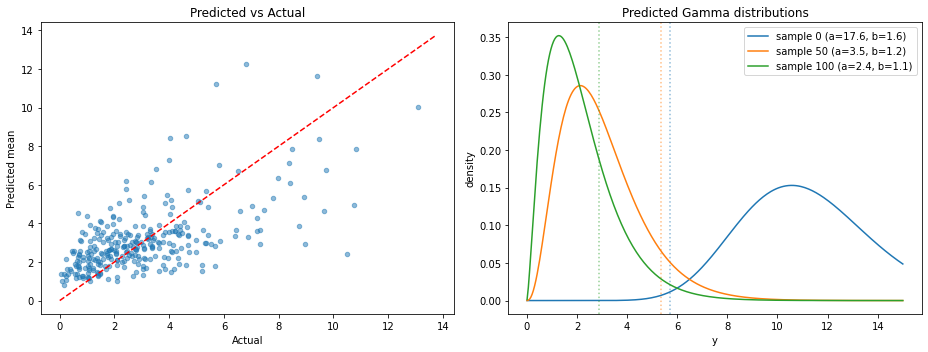

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
lims = [0, max(Y_test.max(), Y_pred.max()) * 1.05]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

ax = axes[1]
x = np.linspace(0.01, 15, 300)
for i in [0, 50, 100]:
    a_i, b_i = dists.alpha[i], dists.beta[i]
    pdf = scipy.stats.gamma.pdf(x, a=a_i, scale=1.0 / b_i)
    ax.plot(x, pdf, label=f"sample {i} (a={a_i:.1f}, b={b_i:.1f})")
    ax.axvline(Y_test[i], color=ax.lines[-1].get_color(), linestyle=":", alpha=0.5)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted Gamma distributions")
ax.legend()

plt.tight_layout()
plt.show()